In [52]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, explained_variance_score, mean_absolute_percentage_error, mean_absolute_error, r2_score, median_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, MultiTaskLasso, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
import shap
import pickle

In [53]:
shap.initjs()

In [2]:
sns.set_theme(style="whitegrid")

In [3]:
def evaluate(predictions, test_features, test_labels):
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    #adjR2 = 1 - (1-sklearn.metrics.r2_score(test_labels, predictions)) * LEN_PART
    print('Model Performance')
    print('Explanes Variance score: {:0.4f} '.format(explained_variance_score(test_labels, predictions)))
    print('Average Error: {:0.4f} days.'.format(np.mean(errors)))
    print('Accuracy MAPE = {:0.2f}%.'.format(mean_absolute_percentage_error(test_labels, predictions)))
    print('MAD = {}.'.format(np.sqrt(median_absolute_error(test_labels, predictions))))
    print('MAE = {}.'.format(mean_absolute_error(test_labels, predictions)))
    print('RMSE = {}.'.format(np.sqrt(mean_squared_error(test_labels, predictions))))
    print('R2 = {}.'.format(r2_score(test_labels, predictions)))
    #print('Adj.R2 = {}.'.format(adjR2))

### Data Load

In [4]:
df = pd.read_csv('../data/real_estate.csv', index_col=0)

### EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1495 entries, 0 to 1494
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Дата          1495 non-null   object 
 1   Тип квартиры  1480 non-null   object 
 2   Район         1433 non-null   object 
 3   Адрес         1494 non-null   object 
 4   Этаж          1492 non-null   object 
 5   Площадь о     1495 non-null   float64
 6   Площадь ж     1495 non-null   float64
 7   Площадь к     1495 non-null   float64
 8   Примечание    1487 non-null   object 
 9   Цена          1495 non-null   int64  
 10  ПТелефон      1495 non-null   object 
 11  Агенство      991 non-null    object 
 12  Email         770 non-null    object 
dtypes: float64(3), int64(1), object(9)
memory usage: 163.5+ KB


In [6]:
df.describe()

,Площадь о,Площадь ж,Площадь к,Цена
count,1495.000000,1495.000000,1495.000000,1495.000000
mean,50.316742,28.568475,7.908127,2679.563211
std,19.876974,17.321094,4.653102,1430.716878
min,13.000000,0.000000,0.000000,230.000000
25%,37.000000,18.000000,6.000000,1850.000000
50%,46.000000,30.000000,7.000000,2500.000000
75%,61.000000,39.000000,9.000000,3100.000000
max,220.000000,150.000000,47.000000,33000.000000


In [7]:
# Удаление времени из даты
df['Дата'] = df['Дата'].str.replace('\d\d:\d\d', '', regex=True)

In [8]:
df = df.loc[df['Этаж'].isna() == False, :]

In [9]:
df.loc[df['Этаж'].isna(), 'Примечание'].to_list()

[]

In [10]:
df.loc[df['Тип квартиры'].isna(), :]

,Дата,Тип квартиры,Район,Адрес,Этаж,Площадь о,Площадь ж,Площадь к,Примечание,Цена,ПТелефон,Агенство,Email
137,22.08,NaN,Правобережный,Грязнова 37,5/5,32.0,18.0,6.0,Продам отличную квартиру в районе с развитой и...,1780,+79226325001 ... Ярославцева Анна Вадимовна,Рио-Люкс,riolux@mail.ru
360,12.08,NaN,Люблино район,Краснодонская 42,1/17,14.3,10.0,3.0,ГОТОВАЯ студия с ремонтом и мебелью!!!\r\n\r\n...,4800,+79095924376 ... Эдуард,Октябрь,schustikovvitaly@yandex.com
412,09.08,NaN,Ленинский,Парковая 21,6/9,24.0,0.0,0.0,"Продается замечательная квартира - студия, общ...",1350,+79123260780 ... Казанцев Дмитрий Викторович,Рио-Люкс,riolux1@mail.ru
453,05.08,NaN,Орджоникидзевский,Карла Маркса 231,10/10,25.3,14.0,5.0,"Продается замечательная квартира - студия, об...",1550,+79123260780 ... Казанцев Дмитрий Викторович,Рио-Люкс,riolux1@mail.ru
489,02.08,NaN,NaN,проспект Просвещения 27,13/15,13.0,12.0,1.0,"В продаже компактная квартира-студия, располож...",2500,79673475776 ...,spb-sz@perspektiva24.com,NaN
570,29.07,NaN,Орджоникидзевский,Зеленый Лог 17,2/10,23.9,15.0,3.0,Продам студию в Орджоникидзевском районе город...,1300,+79615795998 ... Коркина Валентина Сергеевна,Рио-Люкс,rioluks_2@mail.ru
614,03.08,NaN,Орджоникидзевский,Карла Маркса 235,6/10,23.8,0.0,0.0,"Продам уютную квартиру-студию в спокойном, эко...",1750,+79193403814 ... Харин Данил Андреевич,Рио-Люкс,rioluks_2@mail.ru
713,18.07,NaN,Ленинский,Ленина пр-т 18,2/4,26.2,26.2,26.2,"Продается НОВАЯ КВАРТИРА СТУДИЯ.в ЖК ""Театраль...",1300,+79049329419 ... Намоконов Сергей Анатольевич,Рио-Люкс,riolux1@mail.ru
714,18.07,NaN,Ленинский,Ленина пр-т 18,2/4,26.2,26.2,26.2,"Продается НОВАЯ КВАРТИРА СТУДИЯ.в ЖК ""Театраль...",1300,+79049329419 ... Намоконов Сергей Анатольевич,Рио-Люкс,riolux1@mail.ru
727,18.07,NaN,Ленинский,Карла Маркса 68,4/5,18.4,0.0,0.0,Продам квартиру в центре города! Состояние жил...,1000,+79128051795 ... Каландадзе Ольга Юрьевна,Рио-Люкс,rioluks_2@mail.ru


In [11]:
df.loc[df['Район'].isna(), :]

,Дата,Тип квартиры,Район,Адрес,Этаж,Площадь о,Площадь ж,Площадь к,Примечание,Цена,ПТелефон,Агенство,Email
20,26.07,Многокомнатная,NaN,Ленина пр-т 210 стр.А,1/1,200.0,100.0,25.0,Выгодное вложение в свой отдых в самом красиво...,4400,+79128051201 ... Клочко Анна Валерьевна,Рио-Люкс,riolux1@mail.ru
53,02.08,Двухкомнатная,NaN,Новая 1/5,1/2,47.0,29.0,8.0,Продам двухкомнатную квартиру улучшенной плани...,480,+79514596731 ... Яхин Данил Ихсанович,Рио-Люкс,riolux1@mail.ru
70,30.06,Трехкомнатная,NaN,Комсомольская 43,1/1,60.0,45.0,6.0,ДОМ по документам - Квартира с земельным участ...,693,+79227317001 ... Ворожцова Елена Александровна,NaN,riolux1@mail.ru
76,08.08,Трехкомнатная,NaN,Дорожная 71А,1/1,76.5,36.0,8.0,Продам трехкомнатную квартиру приусадебного ти...,2850,+79227229001 ... Балашов Константин Александрович,Рио-Люкс,riolux@mail.ru
88,15.08,Многокомнатная,NaN,Ленина пр-т 129А,1/1,220.0,150.0,20.0,"Продам дачу площадью 230 кв метров, находится ...",5000,+79049329419 ... Намоконов Сергей Анатольевич,Рио-Люкс,riolux1@mail.ru
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1411,28.07,Однокомнатная,NaN,Индустриальная 22/1,2/5,32.2,17.8,5.9,1 комн. квартира по ул. Индустриальная. Общей ...,1650,+79068515202 ... Агния Владимировна,ЖИЛФОНД,NaN
1424,27.01,NaN,NaN,Мира 168,1/2,18.6,10.0,5.0,"Продам квартиру, в хорошем состоянии.В квартир...",500,+79193173203 ... Харитонов Никита Александрович,Рио-Люкс,rioluks_2@mail.ru
1426,28.07,Двухкомнатная,NaN,Зеленый лог 9е,1/3,84.2,30.6,31.2,2 комн. квартира по ул. Зеленый Лог. Общей пло...,4547,+79068510796 ... Алёна Ринатовна,ЖИЛФОНД,NaN
1457,28.07,Четырехкомнатная,NaN,Галиуллина 27,1/5,60.8,43.0,6.0,4 комн. квартира по ул. Галиуллина. Общей площ...,2600,+79068510721 ... Антон Сергеевич,ЖИЛФОНД,NaN


In [12]:
# Разделение этажей
floor = df['Этаж'].str.split('/',  1, expand=True)
floor = floor.fillna(0)
df['Этаж 1'], df['Этаж 2'] = floor[0].astype(int), floor[1].astype(int)

In [13]:
# Разделение даты
date = df['Дата'].str.split('.',  1, expand=True)
df['День'], df['Месяц'] = date.iloc[:,0].astype(int), date.iloc[:,1].astype(int)

In [14]:
df['Тип квартиры'].unique()

array(['Однокомнатная нестандартная', 'Однокомнатная студия',
       'Двухкомнатная нестандартная', 'Однокомнатная полустудия',
       'Трехкомнатная нестандартная', 'Трехкомнатная',
       'Однокомнатная улучшенная', 'Двухкомнатная раздельная',
       'Четырехкомнатная раздельная', 'Трехкомнатная раздельная',
       'Трехкомнатная улучшенная', 'Многокомнатная', 'Однокомнатная',
       'Двухкомнатная', 'Двухкомнатная хрущевка',
       'Трехкомнатная распашонка', 'Четырехкомнатная улучшенная',
       'Трехкомнатная свердловский вариант', 'Двухкомнатная смежная',
       'Двухкомнатная брежневка', 'Двухкомнатная старой планировки',
       'Трехкомнатная брежневка', 'Однокомнатная брежневка',
       'Однокомнатная хабаровский вариант', 'Двухкомнатная улучшенная',
       nan, 'Четырехкомнатная', 'Трехкомнатная Рапашенка',
       'Однокомнатная свердловский вариант', 'Трехкомнатная хрущевка',
       'Однокомнатная хрущевка', 'Однокомнатная сталинский вариант',
       'Однокомнатная малосемей

In [15]:
# Количество комнат
df['Тип квартиры'] = df['Тип квартиры'].str.lower()
df.loc[df['Тип квартиры'].isna(), 'Тип квартиры'] = 'однокомнатная'

df.loc[:, 'Кол-во комнат'] = 0
df.loc[df['Тип квартиры'].str.contains('однокомнатная') == True, 'Кол-во комнат'] = 1
df.loc[df['Тип квартиры'].str.contains('двухкомнатная') == True, 'Кол-во комнат'] = 2
df.loc[df['Тип квартиры'].str.contains('трехкомнатная') == True, 'Кол-во комнат'] = 3
df.loc[df['Тип квартиры'].str.contains('четырехкомнатная') == True, 'Кол-во комнат'] = 4
df.loc[df['Тип квартиры'].str.contains('многокомнатная') == True, 'Кол-во комнат'] = 5

<AxesSubplot:xlabel='Площадь о', ylabel='Count'>

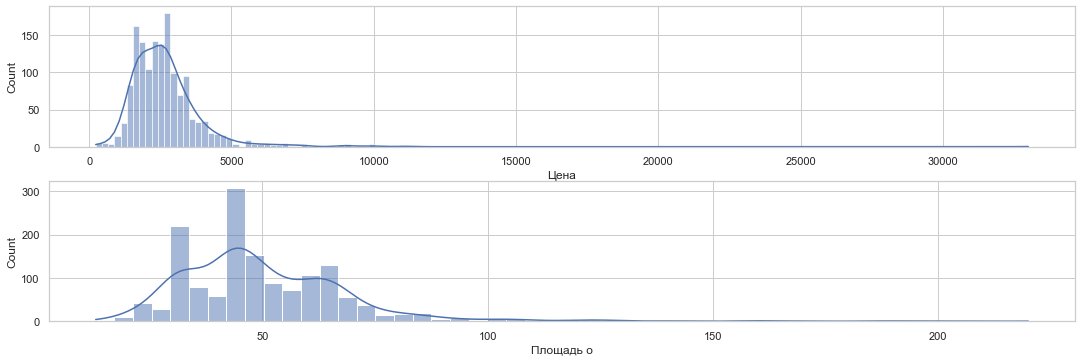

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
fig.tight_layout()
sns.histplot(data=df, x='Цена', kde=True, ax=axes[0])
sns.histplot(data=df, x='Площадь о', kde=True, ax=axes[1])

In [17]:
df.loc[(df['Цена'] > 10000) , :]

,Дата,Тип квартиры,Район,Адрес,Этаж,Площадь о,Площадь ж,Площадь к,Примечание,Цена,ПТелефон,Агенство,Email,Этаж 1,Этаж 2,День,Месяц,Кол-во комнат
300,16.08,двухкомнатная,Ленинский,Комсомольская 1,3/3,65.0,42.0,12.0,"пл.окна,балкон застеклен,2 кладовки,большая ку...",33000,+79193544957 ... diana,NaN,kedr2014@ya.ru,3,3,16,8,2
484,02.08,двухкомнатная,Ленинский,ул. Шаумяна 87,4/17,86.0,0.0,15.0,Пpoдам тpехкомнaтную квартиру в спальном район...,11000,+79068526869 ... Легонькова Милена Анатольевна,Рио-Люкс,riolux@mail.ru,4,17,2,8,2
485,02.08,трехкомнатная,Октябрьский,Тверитина 34,4/17,117.0,0.0,17.0,Трёхкомнатную квартиру в самом сердце Екатерин...,11150,+79068526869 ... Легонькова Милена Анатольевна,Рио-Люкс,riolux@mail.ru,4,17,2,8,3


In [18]:
df.loc[:, ['Район', 'Цена']].groupby('Район').agg({'Цена': ['mean','count']})

Цена      
                                        mean count
Район                                             
10 квартал                       5000.000000     1
Академический                    3300.000000     1
Кировский                        4500.000000     1
Ленинский                        2925.530945   307
Ленинский (Левый берег)          1604.285714     7
Люблино район                    4800.000000     1
Октябрьский                      4405.000000     6
Орджоникидзевский                2741.498246   570
Орджоникидзевский (левый берег)  2198.850000    40
Правобережный                    2527.772819   493
Прикубанский                     3800.000000     1
Промышленный                     1100.000000     1
Тракторозаводский                2550.000000     1

In [19]:
df = df.loc[df['Район'].isin(['Ленинский', 'Правобережный', 
                              'Орджоникидзевский',
                             'Орджоникидзевский (левый берег)', 
                              'Ленинский (Левый берег)']), :]

In [20]:
df = pd.get_dummies(df, columns=['Район'])

<AxesSubplot:>

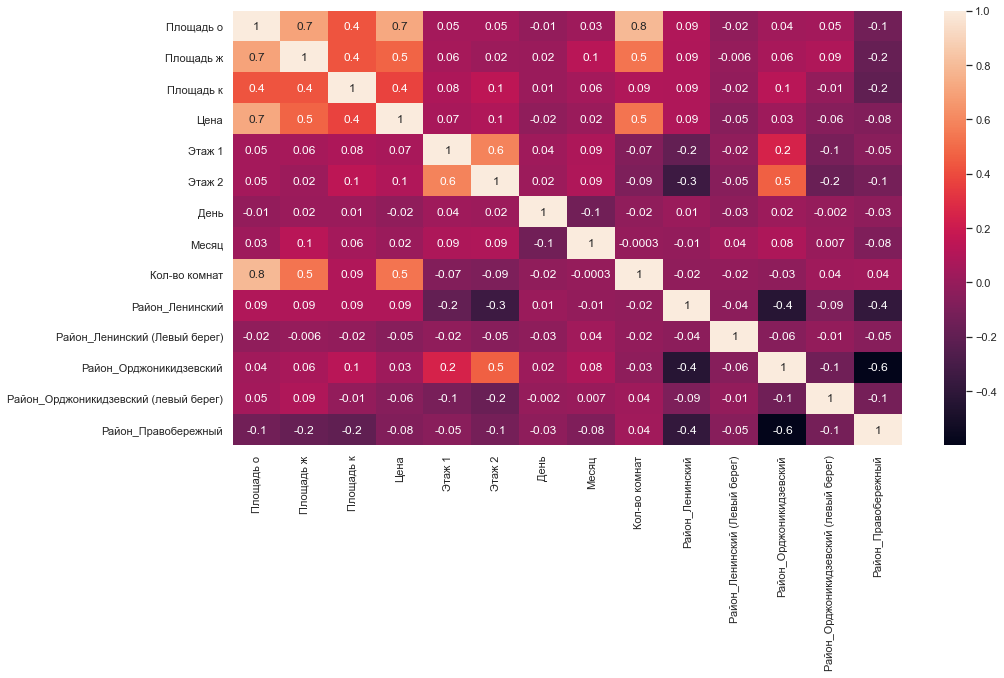

In [16]:
plt.figure(figsize=(15, 8))
sns.heatmap(df.corr(), annot = True, fmt='.1g')

### ML

In [17]:
df

,Дата,Тип квартиры,Адрес,Этаж,Площадь о,Площадь ж,Площадь к,Примечание,Цена,ПТелефон,...,Этаж 1,Этаж 2,День,Месяц,Кол-во комнат,Район_Ленинский,Район_Ленинский (Левый берег),Район_Орджоникидзевский,Район_Орджоникидзевский (левый берег),Район_Правобережный
0,16.08,однокомнатная нестандартная,Московская 20,2/5,43.70,25.0,12.0,Монолитно-каркасный дом комфорт класса.\r\nРаз...,2840,8-919-312-1703 ... Николаева Светлана,...,2,5,16,8,1,1,0,0,0,0
1,16.08,однокомнатная нестандартная,Московская 20,2/5,43.70,25.0,12.0,Монолитно-каркасный дом комфорт класса.\r\nРаз...,2840,8-919-312-1703 ... Николаева Светлана,...,2,5,16,8,1,1,0,0,0,0
2,23.08,однокомнатная студия,Московская 20,4/5,30.00,15.0,10.0,АКЦИЯ!!! Выгода до 250 000 рублей!!!!\r\nВ чес...,1950,"8-912-805-1115, 45-11-15 ... Шарманова Мария",...,4,5,23,8,1,1,0,0,0,0
3,16.08,однокомнатная студия,Московская 20,3/5,31.32,21.0,21.0,Новый дом комфорт класса \r\nРазличные планиро...,2035,8-919-312-1703 ... Николаева Светлана,...,3,5,16,8,1,1,0,0,0,0
4,16.08,двухкомнатная нестандартная,Московская 20,4/5,43.90,25.0,10.0,Новый дом комфорт класса \r\nРазличные планиро...,2853,8-919-312-1703 ... Николаева Светлана,...,4,5,16,8,2,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,15.08,однокомнатная малосемейка,Ленина пр-т 154,3/9,23.00,12.0,5.0,"Продам однокомнатную квартиру (малосемейка), п...",1300,8-9194-002-003 ... Алексей,...,3,9,15,8,1,0,0,1,0,0
1491,06.06,двухкомнатная раздельная,Карла Маркса 72,1/5,44.00,31.0,6.0,"Состояние квартиры обычное, простое, хорошее, ...",1850,8-909-74-72-855 ... Александр Сергеевич Конищев,...,1,5,6,6,2,0,0,0,0,1
1492,06.06,двухкомнатная смежная,Карла Маркса 10,1/5,44.00,31.0,6.0,"Квартира в обычном, жилом, простом состоянии. ...",1850,8-909-74-72-855 ... Александр Сергеевич Конищев,...,1,5,6,6,2,1,0,0,0,0
1493,07.07,трехкомнатная нестандартная,Ленина пр-т 131,4/9,90.00,53.0,14.0,ЗАДАТОК ! За квартиру внесли ЗАДАТОК ! Квартир...,6400,8-909-74-72-855 ... Александр Сергеевич Конищев,...,4,9,7,7,3,0,0,1,0,0


In [65]:
X_columns = ['Площадь о', 
#             'Площадь к', 
            'Этаж 1', 
#             'Этаж 2',
#            'День', 'Месяц', 
#            'Кол-во комнат', 
             'Район_Ленинский',
           'Район_Ленинский (Левый берег)', 'Район_Орджоникидзевский',
           'Район_Орджоникидзевский (левый берег)', 'Район_Правобережный'
            ]

X = df.loc[:, X_columns]
y = df['Цена']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, random_state=56)
scaler = StandardScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=X_columns) 
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_columns) 

In [26]:
l_reg = LinearRegression(n_jobs=-1)
l_reg.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

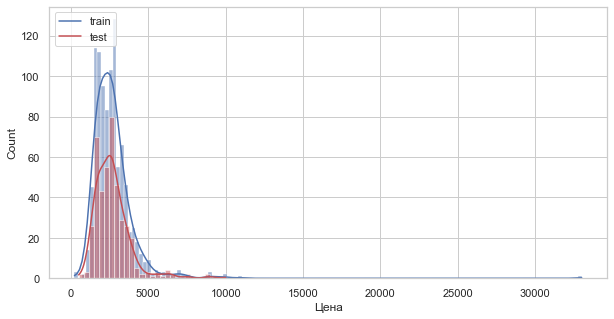

In [180]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
sns.histplot( x=y_train, kde=True, ax=axes, legend=False)
sns.histplot( x=y_test, kde=True, ax=axes, color='r', legend=False)
plt.legend(loc='upper left', labels=['train', 'test'])

In [27]:
# Оценка треина
pred = l_reg.predict(X_train)
evaluate(pred, X_train, y_train) 

Model Performance
Explanes Variance score: 0.4683 
Average Error: 399.1826 days.
Accuracy MAPE = 0.16%.
MAD = 16.131268398799556.
MAE = 399.18259369667766.
RMSE = 1106.1813677648001.
R2 = 0.4682920925509513.


In [28]:
# Оценка теста
pred = l_reg.predict(X_test)
evaluate(pred, X_test, y_test)    

Model Performance
Explanes Variance score: 0.7958 
Average Error: 369.8679 days.
Accuracy MAPE = 0.16%.
MAD = 17.649362594722792.
MAE = 369.8679402845842.
RMSE = 522.3056958421521.
R2 = 0.7948237969497404.


In [32]:
ridge = RidgeCV(cv=5).fit(X_train, y_train)
pred = ridge.predict(X_train)
evaluate(pred, X_train, y_train)

Model Performance
Explanes Variance score: 0.4683 
Average Error: 396.5726 days.
Accuracy MAPE = 0.16%.
MAD = 15.827822439257544.
MAE = 396.57263777887215.
RMSE = 1106.1606064269902.
R2 = 0.4683120510572365.


In [30]:
pred = ridge.predict(X_test)
evaluate(pred, X_test, y_test) 

Model Performance
Explanes Variance score: 0.7979 
Average Error: 367.0425 days.
Accuracy MAPE = 0.15%.
MAD = 17.287749647177282.
MAE = 367.04253141558115.
RMSE = 519.6383491353251.
R2 = 0.7969140618666471.


In [36]:
ridge = LassoCV(cv=5).fit(X_train, y_train)
pred = ridge.predict(X_train)
evaluate(pred, X_train, y_train)

Model Performance
Explanes Variance score: 0.4676 
Average Error: 394.6035 days.
Accuracy MAPE = 0.16%.
MAD = 15.985024793203047.
MAE = 394.603487597927.
RMSE = 1106.889100273044.
R2 = 0.4676115037032902.


In [37]:
pred = ridge.predict(X_test)
evaluate(pred, X_test, y_test) 

Model Performance
Explanes Variance score: 0.7985 
Average Error: 366.2905 days.
Accuracy MAPE = 0.15%.
MAD = 17.31563189215577.
MAE = 366.29053281586243.
RMSE = 519.2600912520419.
R2 = 0.7972096170273362.


##### OLS

In [185]:
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train.reset_index(drop=True), X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Цена   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     144.5
Date:                Fri, 26 Aug 2022   Prob (F-statistic):          2.71e-131
Time:                        15:21:03   Log-Likelihood:                -8351.7
No. Observations:                 991   AIC:                         1.672e+04
Df Residuals:                     984   BIC:                         1.675e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

#### CatBoost

In [66]:
cat = CatBoostRegressor(iterations=950, random_seed=0)

In [67]:
cat.fit(X_train,y_train,verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [68]:
pred = cat.predict(X_train)
evaluate(pred, X_train, y_train) 

Model Performance
Explanes Variance score: 0.9384 
Average Error: 255.2689 days.
Accuracy MAPE = 0.11%.
MAD = 13.31399121670842.
MAE = 255.26885420219978.
RMSE = 376.6535300619259.
R2 = 0.938354053486132.


In [69]:
pred = cat.predict(X_test)
evaluate(pred, X_test, y_test) 

Model Performance
Explanes Variance score: 0.8082 
Average Error: 331.3913 days.
Accuracy MAPE = 0.14%.
MAD = 15.174537016110483.
MAE = 331.3913033083763.
RMSE = 505.08884909839736.
R2 = 0.8081273710756602.


In [28]:
from catboost import Pool, cv

params = {"iterations": 100,
          "depth": 2,
          "loss_function": "RMSE",
          "verbose": False}
cv_dataset = Pool(data=X_train,
                  label=y_train)
scores = cv(cv_dataset,
            params,
            fold_count=5, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 717.02633
bestIteration = 99

Training on fold [1/5]

bestTest = 602.2908036
bestIteration = 99

Training on fold [2/5]

bestTest = 783.5626094
bestIteration = 99

Training on fold [3/5]

bestTest = 615.1269803
bestIteration = 99

Training on fold [4/5]

bestTest = 2075.422356
bestIteration = 99



In [24]:
rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1).fit(X_train, y_train)

In [25]:
pred = rfr.predict(X_train)
evaluate(pred, X_train, y_train) 

Model Performance
Explanes Variance score: 0.8990 
Average Error: 185.7719 days.
Accuracy MAPE = 0.08%.
MAD = 9.94484791236146.
MAE = 185.7719345266451.
RMSE = 482.0718130736841.
R2 = 0.8990180114289588.


In [192]:
pred = rfr.predict(X_test)
evaluate(pred, X_test, y_test) 

Model Performance
Explanes Variance score: 0.7978 
Average Error: 345.9146 days.
Accuracy MAPE = 0.15%.
MAD = 15.64326266054069.
MAE = 345.91463747298286.
RMSE = 518.4744341766052.
R2 = 0.7978228094177259.


In [70]:
pickle.dump(cat, open('../models/cat_model.pkl', 'wb'))

In [150]:
loaded_model = pickle.load(open('../models/cat_model.pkl', 'rb')) 
result = loaded_model.score(X_test, y_test)
print(result)

0.8619935942264121


In [71]:
pickle.dump(scaler, open('../models/scaler.pkl', 'wb'))

In [58]:
X .iloc[0].to_list()

[43.7, 5.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]

In [74]:
pd.DataFrame(scaler.transform([[43.7, 5.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0], 
                              [43.9, 5.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                              [65.0, 9.0, 3.0, 0.0, 0.0, 1.0, 0.0, 0.0]]))

,0,1,2,3,4,5,6,7
0,-0.350357,-0.484934,-1.210438,1.863449,-0.072868,-0.814402,-0.167494,-0.725866
1,-0.339946,-0.484934,-0.102414,1.863449,-0.072868,-0.814402,-0.167494,-0.725866
2,0.758406,0.849736,1.005610,-0.536639,-0.072868,1.227895,-0.167494,-0.725866


In [135]:
cat.predict(scaler.transform([[43.7, 5.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0], 
                              [43.9, 5.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                              [65.0, 9.0, 3.0, 0.0, 0.0, 1.0, 0.0, 0.0]]))

array([2521.99052997, 2227.13604609, 3314.10879128])

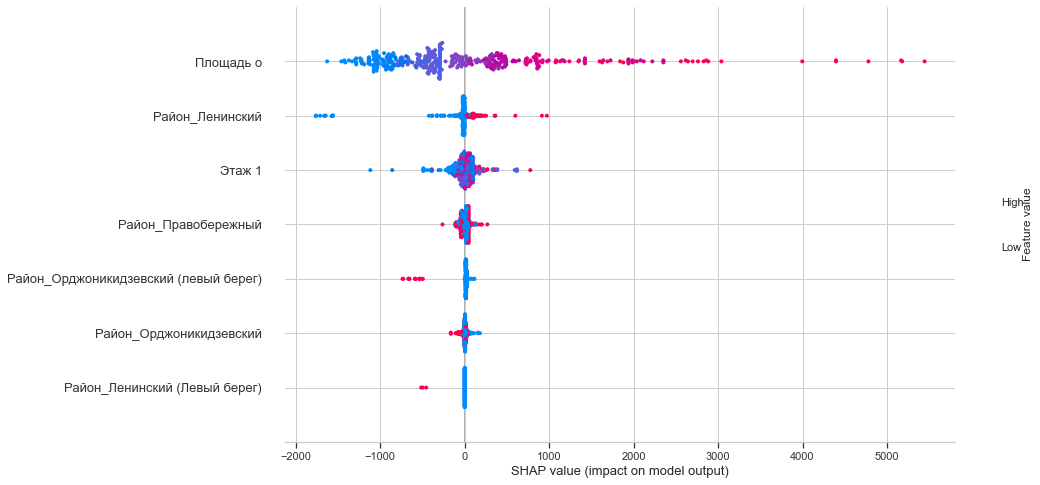

In [54]:
shap_test = shap.TreeExplainer(cat).shap_values(X_test)
shap.summary_plot(shap_test, X_test,
                      max_display=25, plot_size=(15,8))

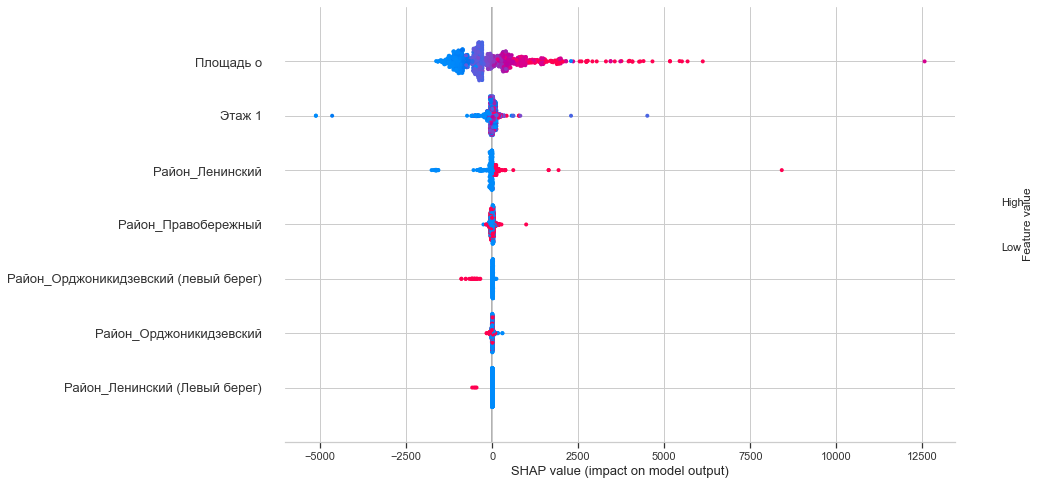

In [56]:
shap_test = shap.TreeExplainer(cat).shap_values(X_train)
shap.summary_plot(shap_test, X_train, plot_size=(15,8))

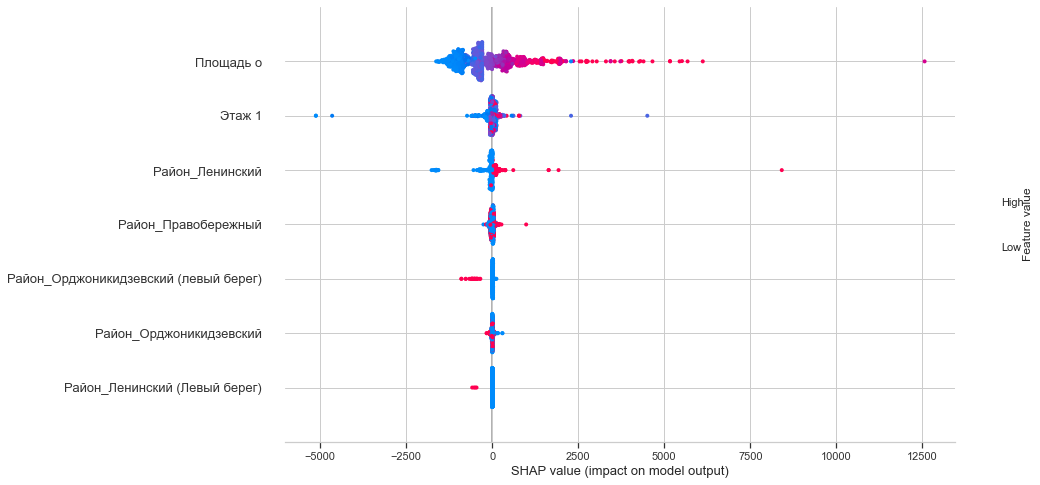

In [51]:
explainer = shap.Explainer(cat)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values, plot_size=(15,8))

In [62]:
len(X_train)

991

In [63]:
len(X_test)

426